# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import mc.pocket as pocket
%aimport mc.pocket
from util import *
%aimport mc.util 
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import scipy

plt.style.use('ggplot')

# T=0

## Monomers

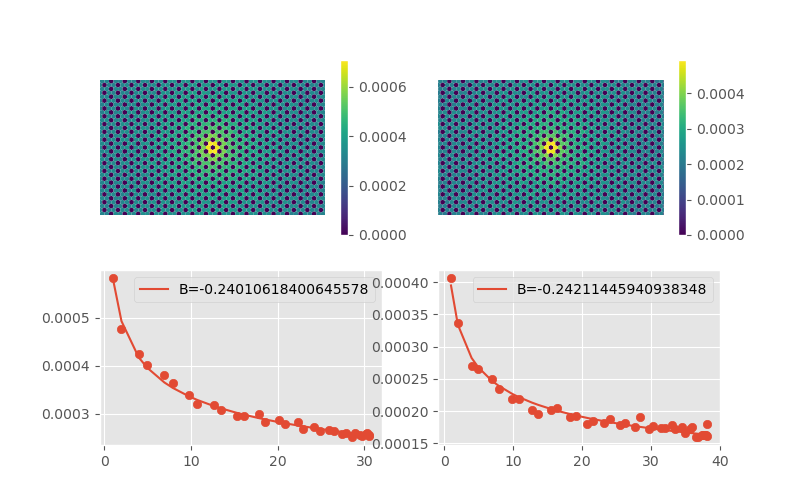

In [72]:
# data1 = read_accumulator("data/t0j0/doped/-1/96x96_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=10)[0].reshape((96, 96))
# data2 = read_accumulator("data/t0j0/doped/-1/120x120_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=10)[0].reshape((120, 120))

# data1 = read_accumulator("data/t0j0/doped2/-1/96x96_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=0)[0].reshape((96, 96))
# data2 = read_accumulator("data/t0j0/doped2/-1/120x120_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=0)[0].reshape((120, 120))

data1 = read_accumulator("data/t0j0/doped/-1/96x96_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=10)[0].reshape((96, 96))
data2 = read_accumulator("data/t0j0/doped/-1/120x120_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=0)[0].reshape((120, 120))

fig, ax = plt.subplots(2, 2, figsize=[8, 5])
plot2d(ax[0, 0], data1)
plot2d(ax[0, 1], data2)

def mod(data, x, y):
    return data.T[x%(data.shape[0]), y%(data.shape[1])]

def symmetrize(data):
    lin = [0]
    xs = np.arange(data.shape[0]//2)
    for i in range(1, data.shape[0]//2):
        total = 0
        total += mod(data, 0, i)
        total += mod(data, i, 0)
        total += mod(data, -i, i)
        total += mod(data, -i, 0)
        total += mod(data, -i, -i)
        total += mod(data, i, -i)
        lin.append(total / 6)
    lin = np.array(lin)

    L = data.shape[0]
    xs = np.sin(np.pi/L * xs) / (np.pi/L)

    indices = np.arange(len(xs))
    return xs[indices % 3 != 0], lin[indices % 3 != 0]

def fit(xs, ys):
    import scipy

    def fun(x, A, B):
        return B * np.power(np.abs(x), A)
    param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=[-0.25, 0.002])

    return fun, param

x1, y1 = symmetrize(data1)
fun, param = fit(x1[:], y1[:])
ax[1, 0].scatter(x1, y1)
ax[1, 0].plot(x1, fun(x1, *param), label=f"B={param[0]}")
# ax[1, 0].set_yscale("log")
# ax[1, 0].set_xscale("log")
ax[1, 0].legend()

x2, y2 = symmetrize(data2)
fun, param = fit(x2[:], y2[:])
ax[1, 1].scatter(x2, y2)
ax[1, 1].plot(x2, fun(x2, *param), label=f"B={param[0]}")
# ax[1, 1].set_yscale("log")
# ax[1, 1].set_xscale("log")
ax[1, 1].legend()

### CFT scaling collapse

In [26]:
# L1, data1 = get_all_data("data/t0j0/doped/-1/*50000000.20_0/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=1, by="l")
# L2, data2 = get_all_data("data/t0j0/doped/-1/96x96_r-3_t0.000000_j0.000_200000000.10_0/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=1, by="l")
# L = []
# data = []
# for l, d in zip(L1, data1):
#     if 12 < l < 96:
#         L.append(l)
#         data.append(d)
# L.append(L2[0])
# data.append(data2[0])

L, data = get_all_data("new-data/t0j0/*/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=1, by="l")

ValueError: new-data/t0j0/108x108_r-3_t0.000000_j0.000_200000000.20_0/mono-mono.dat

IndexError: index 0 is out of bounds for axis 0 with size 0

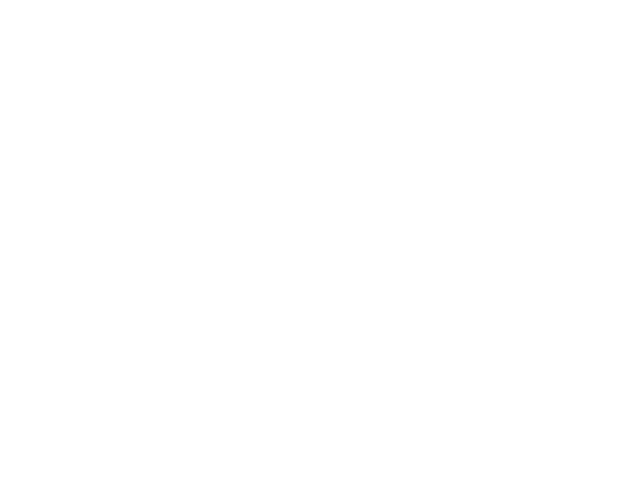

In [23]:
plt.close("all")
plt.figure()
xs = []
ys = []
colors = gen_colors(L)
for l, d in zip(L, data):
    x = np.arange(l)
    scaledx = np.sin(np.pi * x/l) / (np.pi/l)
    scaledx = scaledx/l
    d = d * l**2
    plt.scatter(scaledx[x%3!=0], d[x%3!=0, 0], marker="x", color=colors[l], label="L="+str(l))
    for i in range(d.shape[0]//2):
        if i % 3 == 0: continue
        xs.append(scaledx[i])
        ys.append(d[i, 0])

x = np.linspace(0.005, 1/np.pi, 100)

def fun(x, A, B, C):
    return B * np.exp(np.abs(x) / A) + C
param, _ = scipy.optimize.curve_fit(fun, xs[:20], ys[:20], p0=[-0.25, 1, 1/16], bounds=([-5, 0, 0], [-0.01, np.inf, 100]))
plt.plot(x, fun(x, *param), label=f"Fit $y={param[1]:.2f}e^{{-x/{-param[0]:.2f}}}+{param[2]:.3f}$")

def fun(x, A, B):
    return B * np.power(np.abs(x), A)
param, _ = scipy.optimize.curve_fit(fun, xs[:20], ys[:20], p0=[-0.25, 1], bounds=([-5, 0], [-0.01, np.inf]))
plt.plot(x, fun(x, *param), label=f"Fit $y={param[1]:.2f}x^{{{param[0]:.3f}}}$")

plt.legend()
plt.ylabel("y")
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("$\\overline{x}/L$")

## Trimers

### Scaling

In [6]:
L, data, N = get_all_data("data/t0j0/doped/-1/*20_0/tri-tri.dat", lambda data, props: data[0].reshape((props["l"], props["l"], 2)), skip=3, by="l", with_counts=True)
# L, data = get_all_data("data/t0j0/doped/1.48/*_0/tri-tri.dat", lambda data, props: data[0].reshape((props["l"], props["l"], 2)), skip=30, by="l")
# L, data = get_all_data("data/t0j0/full/*_0/tri-tri.dat", lambda data, props: data[0].reshape((props["l"], props["l"], 2)), skip=50, by="l")

Text(0, 0.5, 'Trimer correlation at L/2')

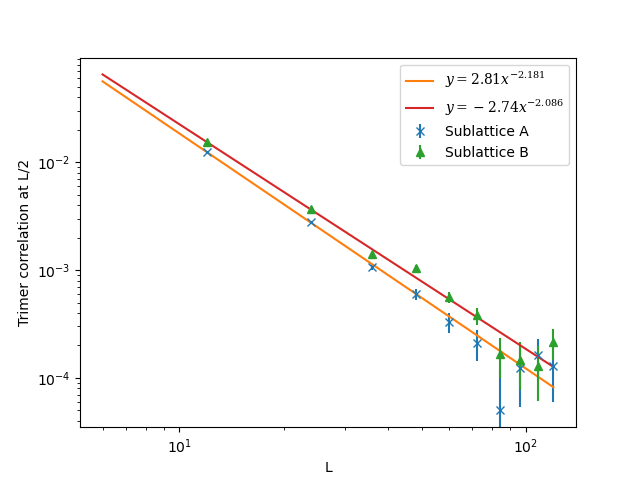

In [16]:
def fit(xs, ys):
    import scipy

    def fun(x, A, B):
        return B * np.power(np.abs(x), A)
    param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=[-2, 1])

    return fun, param

values = []
values2 = []
for l, d in zip(L, data):
    values.append(d[l//2,0,0])
    values2.append(d[l//2,0,1])

values = np.array(values) - 1/6
values2 = -(np.array(values2) - 1/6)

plt.figure()
plt.errorbar(L, values, yerr=np.sqrt((values + 1/6)*(1-values-1/6))/np.sqrt(N*12), ls="", marker="x", label="Sublattice A")
fun, param = fit(L, values)
xs = np.linspace(6, 120, 30)
plt.plot(xs, fun(xs, *param), label=f"$y={param[1]:.2f}x^{{{param[0]:.3f}}}$")

plt.errorbar(L, values2, yerr=np.sqrt((values2 + 1/6)*(1-values2-1/6))/np.sqrt(N*12), ls="", marker="^", label="Sublattice B")
fun, param = fit(L, values2)
xs = np.linspace(6, 120, 30)
plt.plot(xs, fun(xs, *param), label=f"$y=-{param[1]:.2f}x^{{{param[0]:.3f}}}$")

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel("L")
plt.ylabel("Trimer correlation at L/2")

## Entropy per trimer

/tmp/ipykernel_3422754/3413206185.py:21: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  entropies.append(scipy.integrate.quad(fun, 0.06, 50, limit=200)[0])


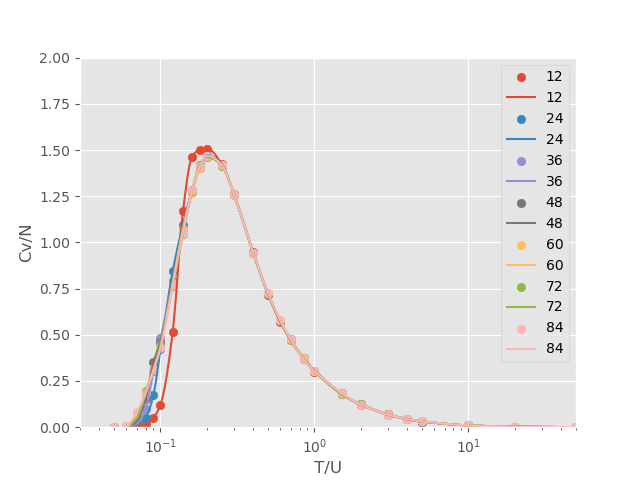

In [58]:
plt.close("all")
plt.figure()
plt.ylabel("Cv/N")
plt.xscale("log")
plt.xlabel("T/U")
plt.xlim([0.03, 50])
plt.ylim([0, 2])

skip = 300000
ls = []
entropies = []
for L in [12, 24, 36, 48, 60, 72, 84]:
    ts1, ds1 = get_all_cvs(f"new-data/vsweeps/single/0/{L}x{L}_r-0_t*_j0.000_20000000.20_0/energy.dat", skip=skip)
    ts2 = np.geomspace(0.06, 50, 200)

    interp = lambda x: np.piecewise(x, [x<0.06, (0.06<=x)*(x<50), 50<=x], [0, scipy.interpolate.PchipInterpolator(ts1, ds1), 0])

    fun = lambda x: interp(x) / x

    ls.append(L)
    entropies.append(scipy.integrate.quad(fun, 0.06, 50, limit=200)[0])

    plt.scatter(ts1, ds1, label=L)
    plt.plot(ts2, interp(ts2), label=L)

ls = np.array(ls)
entropies = np.array(entropies)
plt.legend()

[0.25216424 0.63636567]


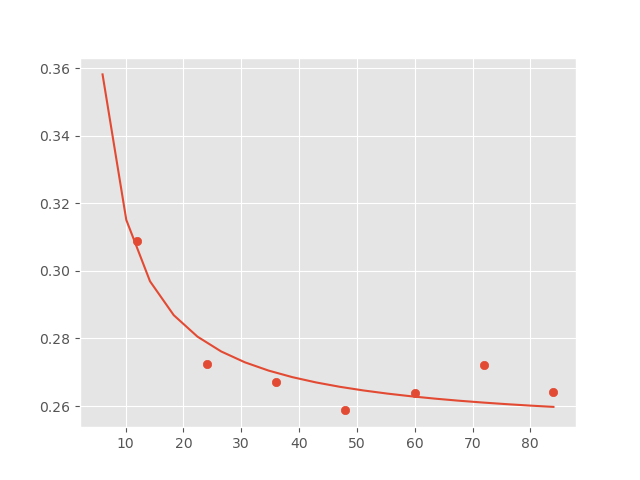

In [57]:
def S(n):
    return 6 * np.log(6) - 5 * np.log(5) - 1/2/n * np.log(5*np.pi*n/3)

plt.figure()
plt.scatter(ls, S(ls**2/3)-entropies)

def fun(x, A, B):
    return A + B/x
param, _ = scipy.optimize.curve_fit(fun, ls[:-1], S(ls[:-1]**2/3)-entropies[:-1])

xs =np.linspace(6, 84, 20)
plt.plot(xs, fun(xs, *param))
print(param)

# T>0

## Weak transitions

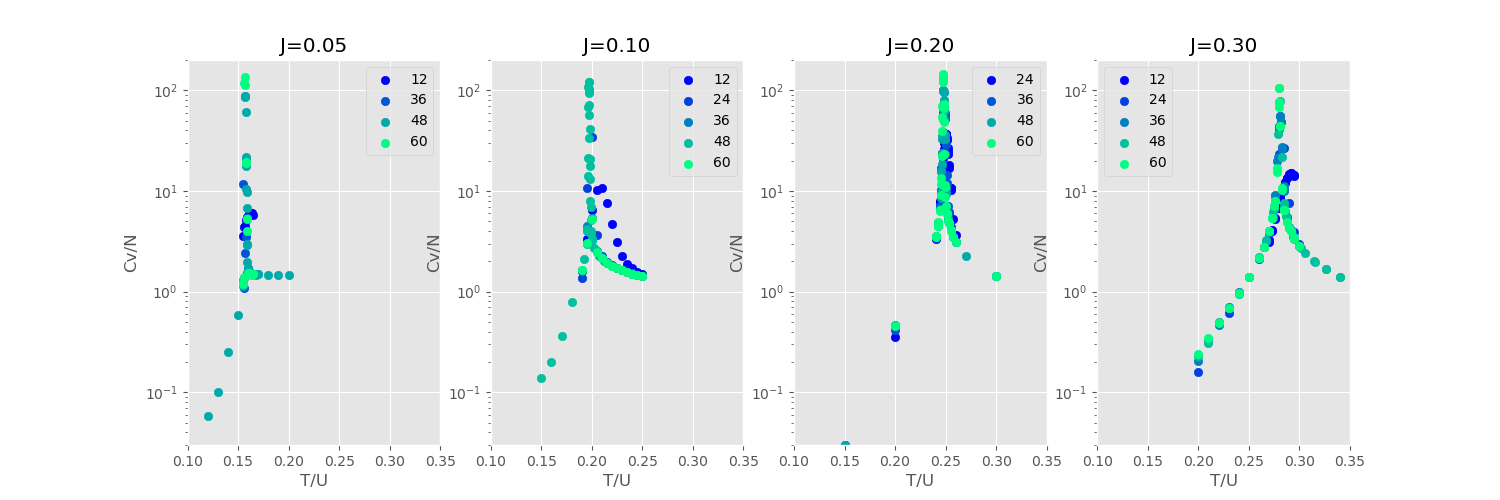

In [61]:
skip = 10000
fig, ax = plt.subplots(1, 4, figsize=[15,5])

def plot(j4, ax):
    curves = get_all_cv_curves([
        f"new-data/vsweeps/pt/{j4}/*/*/*/energy.dat",
        f"new-data/vsweeps/single/{j4}/*/energy.dat",
        f"new-data/vsweeps/rough/{j4}/*/energy.dat",
        f"new-data/vsweeps/roughpt/{j4}/*/*/*/energy.dat"
    ], skip=skip)
    colors = [matplotlib.colormaps["winter"](x) for x in np.linspace(0, 1, len(curves))]
    lens = [c[0] for c in curves]
    for l, t, y in curves:
        ax.scatter(t, y, color=colors[lens.index(l)], label=l)
    ax.legend()

plot("0.05", ax[0])
ax[0].set_title("J=0.05")

plot("0.1", ax[1])
ax[1].set_title("J=0.10")

plot("0.2", ax[2])
ax[2].set_title("J=0.20")

plot("0.3", ax[3])
ax[3].set_title("J=0.30")

# ts0, ds0 = get_all_cvs("new-data/vsweeps/rough/0.1/48*/energy.dat", skip=skip)
# ax[1].plot(ts0, ds0)

# ts0, ds0 = get_all_cvs("new-data/vsweeps/roughpt/0.1/48/0/*/energy.dat", skip=skip)
# ax[1].scatter(ts0, ds0)
# ax[1].set_title("J=0.05")

# ts1, ds1 = get_all_cvs("new-data/vsweeps/single/0.2/24*/energy.dat", skip=skip)
# ax[2].plot(ts1, ds1)
# ts1, ds1 = get_all_cvs("new-data/vsweeps/single/0.2/36*/energy.dat", skip=skip)
# ax[2].plot(ts1, ds1)
# ts1, ds1 = get_all_cvs("new-data/vsweeps/single/0.2/48*/energy.dat", skip=skip)
# ax[2].plot(ts1, ds1)
# ts1, ds1 = get_all_cvs("new-data/vsweeps/single/0.2/60*/energy.dat", skip=skip)
# ax[2].plot(ts1, ds1)

# ts0, ds0 = get_all_cvs("new-data/vsweeps/pt/0.2/48/0/*/energy.dat", skip=skip)
# ax[2].scatter(ts0, ds0)
# ts0, ds0 = get_all_cvs("new-data/vsweeps/pt/0.2/48/1/*/energy.dat", skip=skip)
# ax[2].scatter(ts0, ds0)
# ax[2].set_title("J=0.2")

# ts1, ds1 = get_all_cvs("new-data/vsweeps/single/0.3/24*/energy.dat", skip=skip)
# ax[3].plot(ts1, ds1)
# ts1, ds1 = get_all_cvs("new-data/vsweeps/single/0.3/36*/energy.dat", skip=skip)
# ax[3].plot(ts1, ds1)
# ts1, ds1 = get_all_cvs("new-data/vsweeps/single/0.3/48*/energy.dat", skip=skip)
# ax[3].plot(ts1, ds1)
# ts1, ds1 = get_all_cvs("new-data/vsweeps/single/0.3/60*/energy.dat", skip=skip)
# ax[3].plot(ts1, ds1)

# ts0, ds0 = get_all_cvs("new-data/vsweeps/pt/0.3/48/0/*/energy.dat", skip=skip)
# ax[3].scatter(ts0, ds0)
# ts0, ds0 = get_all_cvs("new-data/vsweeps/pt/0.3/48/1/*/energy.dat", skip=skip)
# ax[3].scatter(ts0, ds0)
# ax[3].set_title("J=0.3")


for a in ax.flatten():
    a.set_ylabel("Cv/N")
    a.set_xlabel("T/U")
    a.set_yscale("log")
    a.set_xlim([0.10, 0.35])
    a.set_ylim([0.03, 200])

In [27]:
from scipy.interpolate import splrep, splev, BSpline

def scaled_spline(t, y, L, tc, nu, k_over_nu, a, omega, s=None):
    xs = (t-tc)/tc * L**(1/nu)
    ys = y * L**(-k_over_nu) * (1 + a * L**(-omega))
    return xs, ys, BSpline(*splrep(xs, ys, np.ones_like(ys)/ys.max(), s=s))
    # return xs, ys, lambda x: np.interp(x, xs, ys)

def fun(x, curves, s):
    tc = x[0]
    nu = x[1]
    k_over_nu = x[2]
    a = x[3]
    omega = x[4]

    all_xs = np.array([])
    all_ys = np.array([])

    minx, maxx = -1000, 1000
    splines = []
    for L, t, y in curves:
        st, sy, spline = scaled_spline(t, y, L, tc, nu, k_over_nu, a, omega, s)
        splines.append(spline)
        all_xs = np.concatenate((all_xs, st))
        all_ys = np.concatenate((all_ys, sy))

    loss = 0

    all_xs = np.sort(all_xs)
    minx, maxx = all_xs[int(len(all_xs)*0.25)], all_xs[int(len(all_xs)*0.75)]

    vals = []
    for x in np.linspace(minx, maxx, 100):
        loss += np.std([s(x) for s in splines])
        vals += [s(x) for s in splines] 

    return loss / np.amax(all_ys)

def fun2(x, curves, s):
    tc = x[0]
    nu = x[1]
    k_over_nu = x[2]

    all_xs = np.array([])
    all_ys = np.array([])
    minx, maxx = -1000, 1000
    for L, t, y in curves:
        st, sy, spline = scaled_spline(t, y, L, tc, nu, k_over_nu, s)
        all_xs = np.concatenate((all_xs, st))
        all_ys = np.concatenate((all_ys, sy))
        minx = max(minx, np.amin(st))
        maxx = min(maxx, np.amax(st))

    indices = np.argsort(all_xs)
    all_xs, all_ys = all_xs[indices], all_ys[indices]

    lower, upper = int(len(all_xs)*0.2), int(len(all_xs)*0.8)
    p = np.polyfit(all_xs[lower:upper], all_ys[lower:upper], 5)
    
    chisq = np.sum((np.polyval(p, all_xs[lower:upper]) - all_xs[lower:upper])**2/np.std(all_xs[lower:upper])**2) * (1/(maxx - minx)+1)
    print(chisq)
    return chisq

def collapse(curves, ax, p0, bounds, s):
    colors = [matplotlib.colormaps["viridis"](x) for x in np.linspace(0, 1, len(curves))]
    lens = [c[0] for c in curves]

    for L, t, y in curves:
        ax[0].scatter(t, y, color=colors[lens.index(L)], label=L)
    ax[0].set_yscale('log')
    ax[0].legend()

    res = scipy.optimize.minimize(fun, p0, bounds=bounds, args=(curves, s))
    tc, nu, k_over_nu, a, omega = res.x
    print(res)

    maxy = 0
    allx, ally = np.array([]), np.array([])

    for L, t, y in curves:
        st, sy, spline = scaled_spline(t, y, L, tc, nu, k_over_nu, a, omega, s)
        maxy = max(maxy, np.amax(sy))
        allx = np.concatenate((allx, st))
        ally = np.concatenate((ally, sy))

        xs = np.linspace(-20, 20, 100)
        ax[1].scatter(st, sy, color=colors[lens.index(L)], label=L)
        ax[1].plot(xs, spline(xs), color=colors[lens.index(L)])

    indices = np.argsort(allx)
    allx, ally = allx[indices], ally[indices]

    lower, upper = int(len(allx)*0.2), int(len(allx)*0.8)

    # p, residuals, _, _, _ = np.polyfit(allx[lower:upper], ally[lower:upper], 8, full=True)
    # xs = np.linspace(allx[lower], allx[upper], 100)
    # ax[1].plot(xs, np.polyval(p, xs))

    ax[1].set_xlim([allx[int(len(allx)*0.2)], allx[int(len(allx)*0.8)]])
    ax[1].set_ylim([0, maxy*1.1])
    ax[1].legend()
    ax[1].set_title(f"$J_4=0.2, T_c={tc:.3f}, \\nu={nu:.2f}, \\kappa/\\nu={k_over_nu:.2f}$")
    print(tc, nu, k_over_nu, a, omega)

In [28]:
from scipy.interpolate import splrep, splev, BSpline

def rescale(t, y, L, tc, nu, k_over_nu, a, omega):
    xs = (t-tc)/tc * L**(1/nu)
    ys = y * L**(-k_over_nu) * (1 + a * L**(-omega))**(-1.)
    return xs, ys

def collapse2(curves, ax, bounds, yvar_name, exponent_name):
    colors = gen_colors(curves)

    p = None
    boundmin = None
    boundmax = None
    def fun(x, curves, deg):
        nonlocal p, boundmin, boundmax
        tc, nu, k_over_nu, a, omega = x
        boundmin = -np.inf
        boundmax = np.inf
        xmin = np.inf
        xmax = -np.inf
        all_xs, all_ys = [], []
        for L, t, y in curves:
            st, sy = rescale(t, y, L, tc, nu, k_over_nu, a, omega)
            all_xs = np.concatenate((all_xs, st))
            all_ys = np.concatenate((all_ys, sy))
            boundmin = max(boundmin, np.amin(st))
            boundmax = min(boundmax, np.amax(st))
            xmin = min(xmin, np.amin(st))
            xmax = max(xmax, np.amax(st))

        indices = (all_xs>=boundmin)*(all_xs<=boundmax)
        all_xs, all_ys = all_xs[indices], all_ys[indices]

        p = np.polyfit(all_xs, all_ys, deg)
        chisq = np.sum((np.polyval(p, all_xs) - all_ys)**2/np.std(all_ys)**2) * ((xmax - xmin)/(boundmax-boundmin))
        return chisq

    for L, t, y in curves:
        ax[0].scatter(t, y, color=colors[L], label=L)

    p0 = []
    pbounds = []
    for prop in ["tc", "nu", "k_over_nu", "a", "omega"]:
        if isinstance(bounds[prop], tuple):
            pbounds.append(bounds[prop])
            p0.append((bounds[prop][0] + bounds[prop][1])/2)
        else:
            pbounds.append((bounds[prop], bounds[prop]))
            p0.append(bounds[prop])

    res = scipy.optimize.minimize(fun, p0, bounds=pbounds, args=(curves, 8))
    tc, nu, k_over_nu, a, omega = res.x

    allx, ally = np.array([]), np.array([])
    for L, t, y in curves:
        st, sy = rescale(t, y, L, tc, nu, k_over_nu, a, omega)
        allx = np.concatenate((allx, st))
        ally = np.concatenate((ally, sy))
        ax[1].scatter(st, sy, color=colors[L], label=L)

    xs = np.linspace(boundmin, boundmax, 100)
    yrange = np.amax(ally) - np.amin(ally)
    ax[1].set_ylim([np.amin(ally)-yrange*0.05, np.amax(ally)+yrange*0.05])
    ax[1].plot(xs, np.polyval(p, xs))

    ax[0].set_ylabel(f"${yvar_name}$")
    ax[0].set_xlabel("$T$")
    if exponent_name is None:
        ax[1].set_title(f"$T_c={tc:.3f}, \\nu={nu:.2f}$")
        ax[1].set_ylabel(f"${yvar_name}$")
    else:
        ax[1].set_title(f"$T_c={tc:.3f}, \\nu={nu:.2f}, {exponent_name}={k_over_nu*nu:.2f}$")
        ax[1].set_ylabel(f"${yvar_name} L^{{-{exponent_name}/\\nu}}$")
    ax[1].set_xlabel("$(T-T_c)L^{-\\nu}/T_c$")
    print(res.x)



### J=0.1

[ 1.96185935e-01  6.21644820e-01  1.46623435e+00 -4.13359445e-08
 -6.43220285e-13]
[ 1.96395831e-01  7.08319686e-01  0.00000000e+00 -1.86558792e-06
  5.40374592e-07]
[ 1.95875235e-01  7.62604166e-01  1.31304287e+00 -1.14437757e-06
 -1.88473839e-10]


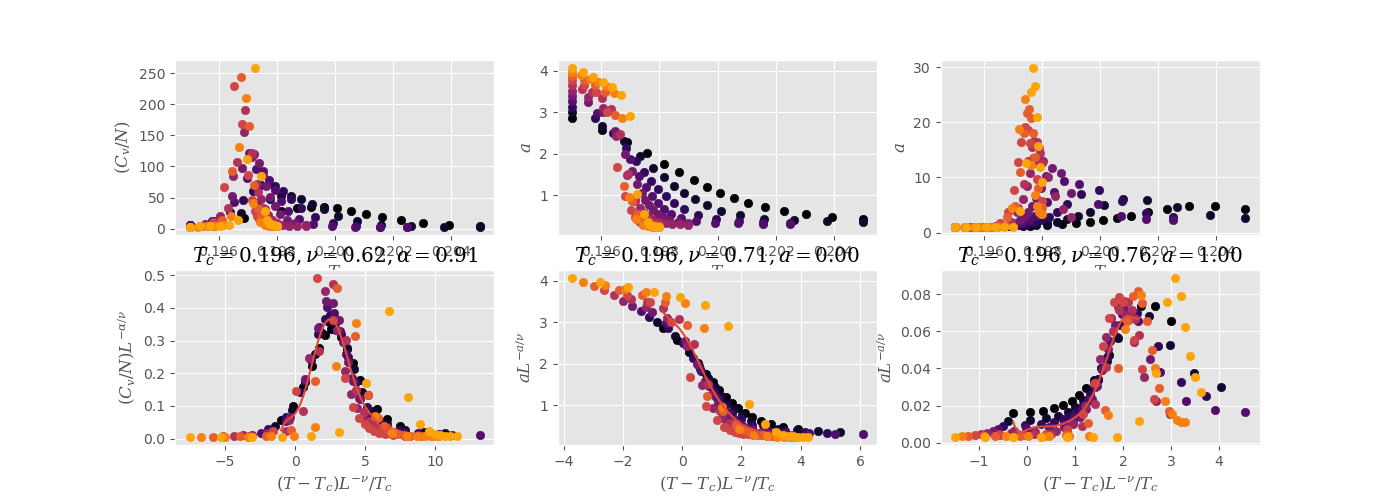

In [21]:
skip=250000
fig, ax = plt.subplots(2, 3, figsize=[14,5])

# curves = get_all_curves(["new-data/vsweeps/pt/0.2/*/*/*/energy.dat"], bounds=[0.23, 0.27])
# curves = get_all_curves(["new-data/pto/0.2/*/energy.dat"], bounds=[0.23, 0.27])
# collapse(curves, ax, (0.2467, 0.63, 1.5, 0, 0), [(0.246, 0.247), (0.55, 0.65), (1.45, 1.55), (-0.05, 0.05), (-1, 1)], 0.03)

curves = [c for c in get_all_curves(["new-data/vsweeps/binder/0.1/*/energy.dat"], skip=skip)]
collapse2(curves, ax[:, 0], {
    "tc": (0.195, 0.197),
    "nu":  (0.4, 0.8),
    "k_over_nu": (1.3, 1.6),
    "a": (-1, 1),
    "omega": (-3, 3),
}, "(C_v/N)", "\\alpha")

curves = [c for c in get_all_curves(["new-data/vsweeps/binder/0.1/*/order.dat"], skip=skip, prop="corr")]
collapse2(curves, ax[:, 1], {
    "tc": (0.195, 0.197),
    "nu": (0.4, 0.8),
    "k_over_nu": 0,
    "a": (-1, 1),
    "omega": (-3, 3),
}, "a", "a")

curves = [c for c in get_all_curves(["new-data/vsweeps/binder/0.1/*/order.dat"], skip=skip, prop="kb")]
collapse2(curves, ax[:, 2], {
    "tc": (0.195, 0.197),
    "nu":  (0.4, 0.8),
    "k_over_nu": (-0.5, 1.5),
    "a": (-1, 1),
    "omega": (-3, 3),
}, "a", "a")

### J=0.2

[ 2.46700000e-01  5.60883554e-01  1.52175196e+00 -3.28266115e-05
  1.23034962e-07]
[2.46700000e-01 5.63928419e-01 4.02673089e-02 2.37155532e-07
 5.66127070e-09]
[ 2.46700000e-01  5.33057730e-01 -7.79388908e-02 -1.30752302e-06
  1.04909090e-06]


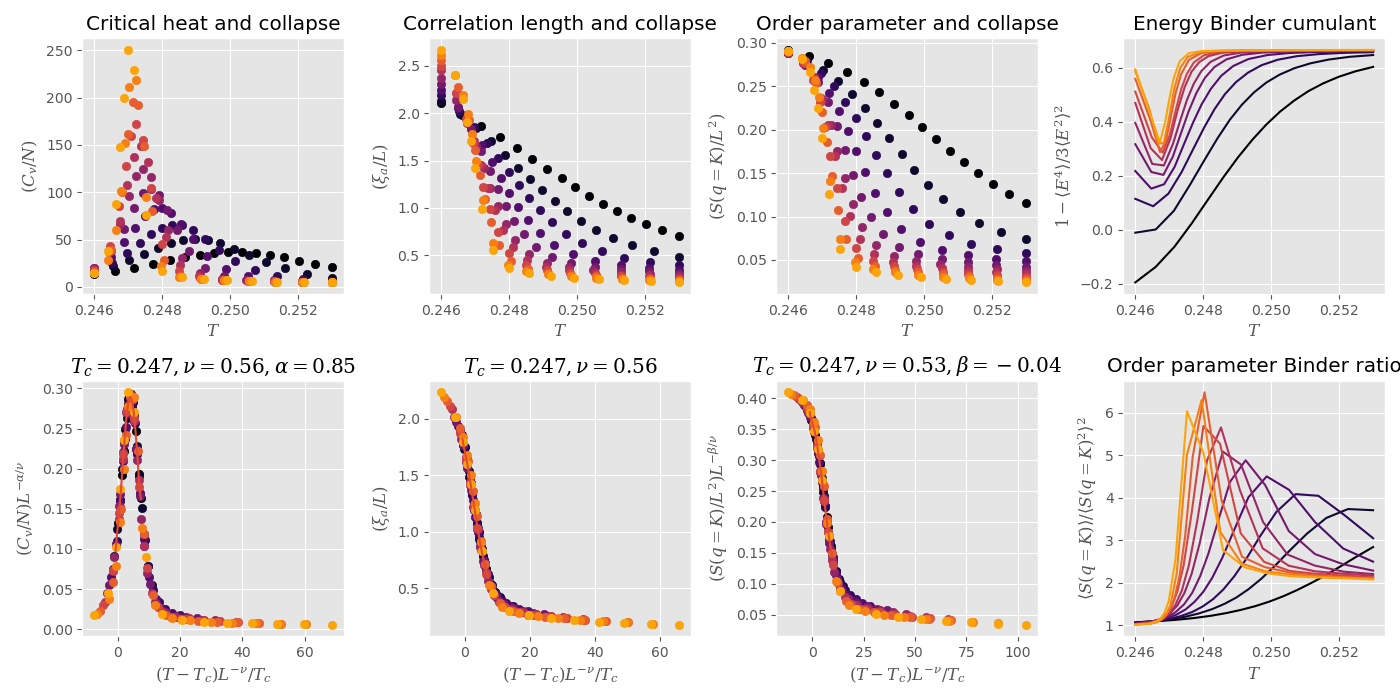

In [18]:
skip=50000
plt.close("all")
fig, ax = plt.subplots(2, 4, figsize=[14,7])

# curves = get_all_curves(["new-data/vsweeps/pt/0.2/*/*/*/energy.dat"], bounds=[0.23, 0.27])
# curves = get_all_curves(["new-data/pto/0.2/*/energy.dat"], bounds=[0.23, 0.27])

curves = [c for c in get_all_curves(["new-data/vsweeps/binder/0.2d/*/energy.dat"], bounds=[0.23, 0.27])]
collapse2(curves, ax[:, 0], {
    "tc": (0.2466, 0.2467),
    "nu": (0.5, 0.6),
    "k_over_nu": (1.3, 1.6),
    "a": (-1, 1),
    "omega": (-3, 3),
}, "(C_v/N)", "\\alpha")

curves = [c for c in get_all_curves(["new-data/vsweeps/binder/0.2d/*/order.dat"], prop="corr")]
collapse2(curves, ax[:, 1], {
    "tc": (0.2466, 0.2467),
    "nu": (0.5, 0.65),
    "k_over_nu": (-0.5, 0.5),
    "a": (-1, 1),
    "omega": (-3, 3),
}, "(\\xi_a/L)", None)

curves = [c for c in get_all_curves(["new-data/vsweeps/binder/0.2d/*/order.dat"], prop="k")]
collapse2(curves, ax[:, 2], {
    "tc": (0.2466, 0.2467),
    "nu": (0.5, 0.6),
    "k_over_nu": (-1, 1),
    "a": (-1, 1),
    "omega": (-3, 3),
}, "(S(q=K)/L^2)", "\\beta")
ax[0, 0].set_title("Critical heat and collapse")
ax[0, 1].set_title("Correlation length and collapse")
ax[0, 2].set_title("Order parameter and collapse")

curves = [c for c in get_all_curves(["new-data/vsweeps/binder/0.2f/*/energy.dat"], prop="eb")]
colors = gen_colors(curves)
for L, t, y in curves:
    ax[0, 3].plot(t, y, color=colors[L])
ax[0, 3].set_title("Energy Binder cumulant")
ax[0, 3].set_xlabel("$T$")
ax[0, 3].set_ylabel("$1-\\langle E^4 \\rangle/3\\langle E^2\\rangle^2$")

curves = [c for c in get_all_curves(["new-data/vsweeps/binder/0.2d/*/order.dat"], prop="kb")]
colors = gen_colors(curves)
for L, t, y in curves:
    ax[1, 3].plot(t, y, color=colors[L])
ax[1, 3].set_title("Order parameter Binder ratio")
ax[1, 3].set_ylabel("$\\langle S(q=K) \\rangle/\\langle S(q=K)^2\\rangle^2$")
ax[1, 3].set_xlabel("$T$")

fig.tight_layout()

In [ ]:
skip=50000
fig, ax = plt.subplots(2, 4, figsize=[14,7])

# curves = get_all_curves(["new-data/vsweeps/pt/0.2/*/*/*/energy.dat"], bounds=[0.23, 0.27])
# curves = get_all_curves(["new-data/pto/0.2/*/energy.dat"], bounds=[0.23, 0.27])
# collapse(curves, ax, (0.2467, 0.63, 1.5, 0, 0), [(0.246, 0.247), (0.55, 0.65), (1.45, 1.55), (-0.05, 0.05), (-1, 1)], 0.03)

curves = [c for c in get_all_curves(["new-data/vsweeps/binder/0.3/*/energy.dat"])]
collapse2(curves, ax[:, 0], {
    "tc": (0.27, 0.29),
    "nu": (0.5, 0.6),
    "k_over_nu": (1.3, 1.6),
    "a": (-1, 1),
    "omega": (-3, 3),
}, "", "")

curves = [c for c in get_all_curves(["new-data/vsweeps/binder/0.3/*/order.dat"], prop="corr")]
collapse2(curves, ax[:, 1], {
    "tc": (0.27, 0.29),
    "nu": (0.5, 0.6),
    "k_over_nu": (-0.5, 0.5),
    "a": (-1, 1),
    "omega": (-3, 3),
}, "", "")

curves = [c for c in get_all_curves(["new-data/vsweeps/binder/0.3/*/order.dat"], prop="k")]
collapse2(curves, ax[:, 2], {
    "tc": (0.27, 0.29),
    "nu": (0.5, 0.6),
    "k_over_nu": (-1, 1),
    "a": (-1, 1),
    "omega": (-3, 3),
}, "", "")

curves = [c for c in get_all_curves(["new-data/vsweeps/binder/0.2f/*/energy.dat"], prop="eb")]
colors = gen_colors(curves)
for L, t, y in curves:
    ax[0, 3].plot(t, y, color=colors[L])
ax[0, 3].set_title("Energy Binder cumulant")
ax[0, 3].set_xlabel("$T$")
ax[0, 3].set_ylabel("$1-\\langle E^4 \\rangle/3\\langle E^2\\rangle^2$")

curves = [c for c in get_all_curves(["new-data/vsweeps/binder/0.2d/*/order.dat"], prop="kb")]
colors = gen_colors(curves)
for L, t, y in curves:
    ax[1, 3].plot(t, y, color=colors[L])
ax[1, 3].set_title("Order parameter Binder ratio")
ax[1, 3].set_ylabel("$\\langle S(q=K) \\rangle/\\langle S(q=K)^2\\rangle^2$")
ax[1, 3].set_xlabel("$T$")

fig.tight_layout()

[2.79183132e-01 5.57970416e-01 1.32921286e+00 1.26421178e-06
 1.47437307e-08]
[ 2.79246264e-01  6.00000000e-01 -8.52640062e-02 -1.30643480e-09
  2.24693982e-11]
[ 2.79083215e-01  5.60261065e-01 -9.14540389e-02  2.80984934e-08
  3.61791117e-10]


IndexError: index 3 is out of bounds for axis 1 with size 3

ValueError: 
$$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous view', 'arrow-left', 'back'), ('Forward', 'Forward to next view', 'arrow-right', 'forward'), ('Pan', 'Left button pans, Right button zooms\nx/y fixes axis, CTRL fixes aspect', 'arrows', 'pan'), ('Zoom', 'Zoom to rectangle\nx/y fixes axis', 'square-o', 'zoom'), ('Download', 'Download plot', 'floppy-o', 'save_figure')]))

ValueError: 
$$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

## Strong transitions

### J=0.01

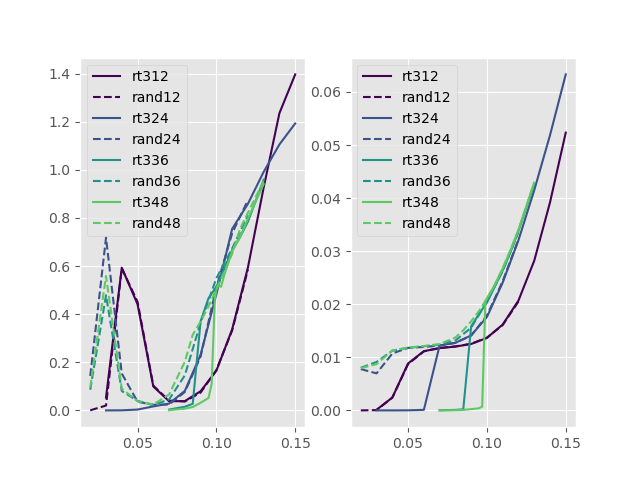

In [2]:
fig, ax = plt.subplots(1, 2)
skip=100000

Ls = [12, 24, 36, 48]
colors = [matplotlib.colormaps["viridis"](x) for x in np.linspace(0, 1, 5)]
colormap = {Ls[i]: colors[i] for i in range(len(Ls))}

for l in Ls:
    for init in ["rt3", "rand"]:
        ls = "--" if init == "rand" else None
        ts2, ds2 = get_all_cvs(f"new-data/vsweeps/rough/0.01/{init}/{l}*/energy.dat", skip=skip)
        ax[0].plot(ts2, ds2, label=init+str(l), ls=ls, color=colormap[l])
        ts2, ds2 = get_all_energies(f"new-data/vsweeps/rough/0.01/{init}/{l}*/energy.dat", skip=skip)
        ax[1].plot(ts2, ds2, label=init+str(l), ls=ls, color=colormap[l])
ax[0].legend()
ax[1].legend()

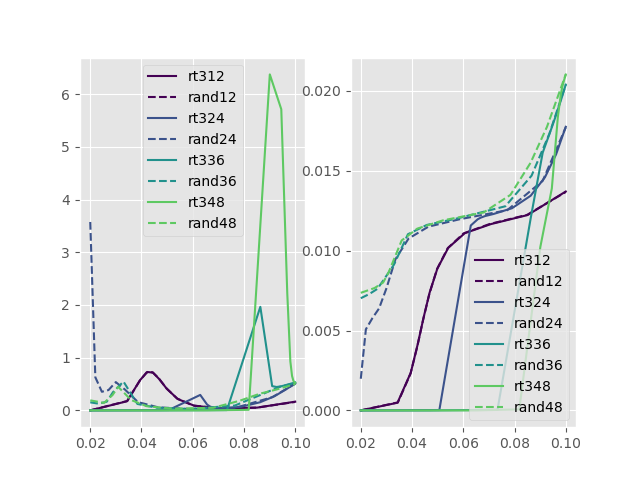

In [4]:
fig, ax = plt.subplots(1, 2)
skip=0

Ls = [12, 24, 36, 48]
colors = [matplotlib.colormaps["viridis"](x) for x in np.linspace(0, 1, 5)]
colormap = {Ls[i]: colors[i] for i in range(len(Ls))}

for l in Ls:
    for init in ["rt3", "rand"]:
        ls = "--" if init == "rand" else None
        ts2, ds2 = get_all_cvs(f"new-data/pto/0.01/{init}/{l}*/energy.dat", skip=skip)
        ax[0].plot(ts2, ds2, label=init+str(l), ls=ls, color=colormap[l])
        ts2, ds2 = get_all_energies(f"new-data/pto/0.01/{init}/{l}*/energy.dat", skip=skip)
        ax[1].plot(ts2, ds2, label=init+str(l), ls=ls, color=colormap[l])
ax[0].legend()
ax[1].legend()

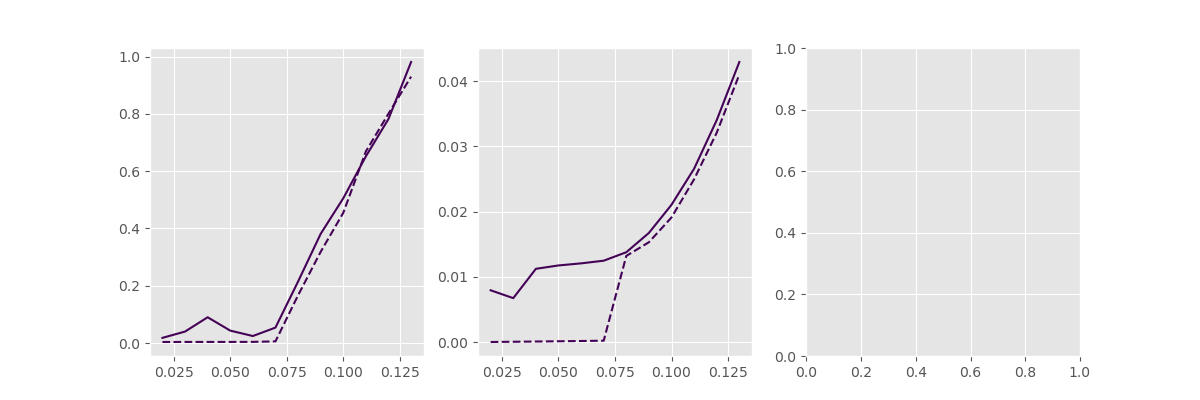

In [19]:
fig, ax = plt.subplots(1, 3, figsize=[12, 4])

curves = get_all_curves(["new-data/vsweeps/rough/0.01r3/rand/*/energy.dat"], prop="cv", skip=500000)
colors = gen_colors(curves)
for l, t, kb in curves:
    ax[0].plot(t, kb, label=l, color=colors[l])

curves = get_all_curves(["new-data/vsweeps/rough/0.01r3/rt3/*/energy.dat"], prop="cv", skip=500000)
colors = gen_colors(curves)
for l, t, kb in curves:
    ax[0].plot(t, kb, label=l, color=colors[l], ls="--")

curves = get_all_curves(["new-data/vsweeps/rough/0.01r3/rand/*/energy.dat"], prop="e", skip=500000)
colors = gen_colors(curves)
for l, t, kb in curves:
    ax[1].plot(t, kb, label=l, color=colors[l])

curves = get_all_curves(["new-data/vsweeps/rough/0.01r3/rt3/*/energy.dat"], prop="e", skip=500000)
colors = gen_colors(curves)
for l, t, kb in curves:
    ax[1].plot(t, kb, label=l, color=colors[l], ls="--")

### J=-0.1

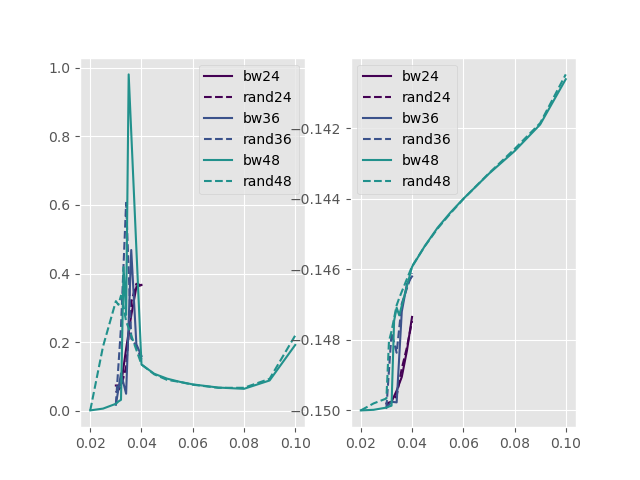

In [36]:
fig, ax = plt.subplots(1, 2)
skip=100000

Ls = [24, 36, 48]
colors = [matplotlib.colormaps["viridis"](x) for x in np.linspace(0, 1, 5)]
colormap = {Ls[i]: colors[i] for i in range(len(Ls))}

for l in Ls:
    for init in ["bw", "rand"]:
        ls = "--" if init == "rand" else None
        ts2, ds2 = get_all_cvs(f"new-data/vsweeps/rough/-0.1/{init}/{l}*/energy.dat", skip=skip)
        ax[0].plot(ts2, ds2, label=init+str(l), ls=ls, color=colormap[l])
        ts2, ds2 = get_all_energies(f"new-data/vsweeps/rough/-0.1/{init}/{l}*/energy.dat", skip=skip)
        ax[1].plot(ts2, ds2, label=init+str(l), ls=ls, color=colormap[l])
ax[0].legend()
ax[1].legend()

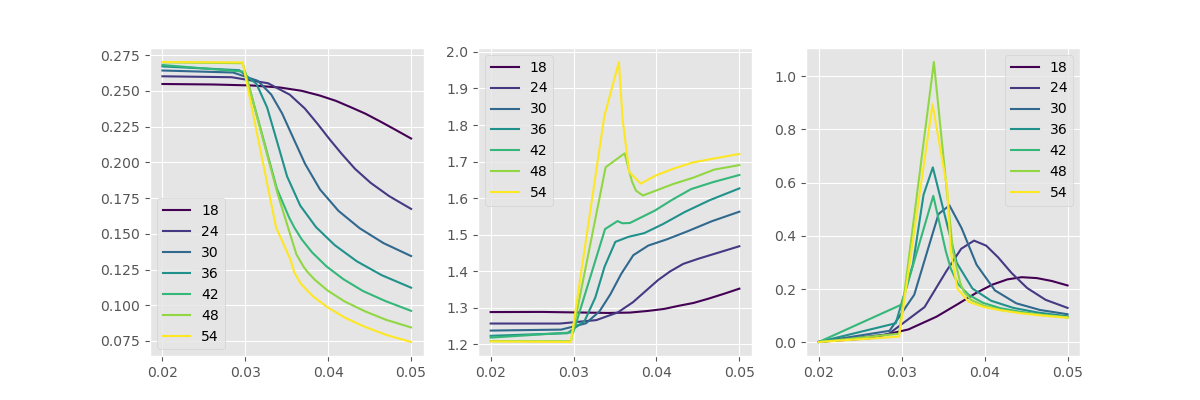

In [6]:
fig, ax = plt.subplots(1, 3, figsize=[12, 4])
curves = get_all_curves(["new-data/pto/-0.1/*/order.dat"], prop="m")
colors = gen_colors(curves)
for l, t, kb in curves:
    ax[0].plot(t, kb, label=l, color=colors[l])
ax[0].legend()
curves = get_all_curves(["new-data/pto/-0.1/*/order.dat"], prop="mb")
for l, t, kb in curves:
    ax[1].plot(t, kb, label=l, color=colors[l])
ax[1].legend()
curves = get_all_curves(["new-data/pto/-0.1/*/energy.dat"], prop="cv")
for l, t, kb in curves:
    ax[2].plot(t, kb, label=l, color=colors[l])
ax[2].legend()

In [ ]:
fig, ax = plt.subplots(1, 2)
skip=100000
Ls = [12, 24, 36, 48]
colors = [matplotlib.colormaps["viridis"](x) for x in np.linspace(0, 1, 5)]
colormap = {Ls[i]: colors[i] for i in range(len(Ls))}

for l in Ls:
    for init in ["rt3", "rand"]:
        ls = "--" if init == "rand" else None
        ts2, ds2 = get_all_cvs(f"new-data/vsweeps/rough/0.01/{init}/{l}*/energy.dat", skip=skip)
        ax[0].plot(ts2, ds2, label=init+str(l), ls=ls, color=colormap[l])
        ts2, ds2 = get_all_energies(f"new-data/vsweeps/rough/0.01/{init}/{l}*/energy.dat", skip=skip)
        ax[1].plot(ts2, ds2, label=init+str(l), ls=ls, color=colormap[l])
ax[0].legend()
ax[1].legend()

## Horizontal sweeps

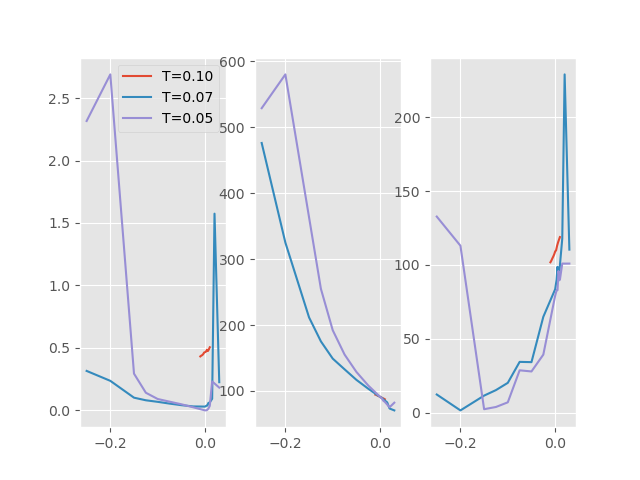

In [4]:
skip=10000
fig, ax = plt.subplots(1, 3)
j4, cv = get_all_cvs("new-data/hsweeps/0.1/*/energy.dat", by="j4", skip=skip)
ax[0].plot(j4, cv, label="T=0.10")
j4, cv = get_all_cvs("new-data/hsweeps/0.07/*/energy.dat", by="j4", skip=skip)
ax[0].plot(j4, cv, label="T=0.07")
j4, cv = get_all_cvs("new-data/hsweeps/0.05/*/energy.dat", by="j4", skip=skip)
ax[0].plot(j4, cv, label="T=0.05")
ax[0].legend()

j4, cv = get_all_data("new-data/hsweeps/0.1/*/order.dat", lambda data, props: data[0], by="j4", skip=skip)
ax[1].plot(j4, cv[:, 0])
ax[2].plot(j4, cv[:, 3])
j4, cv = get_all_data("new-data/hsweeps/0.07/*/order.dat", lambda data, props: data[0], by="j4", skip=skip)
ax[1].plot(j4, cv[:, 0])
ax[2].plot(j4, cv[:, 3])
j4, cv = get_all_data("new-data/hsweeps/0.05/*/order.dat", lambda data, props: data[0], by="j4", skip=skip)
ax[1].plot(j4, cv[:, 0])
ax[2].plot(j4, cv[:, 3])

KeyboardInterrupt: 

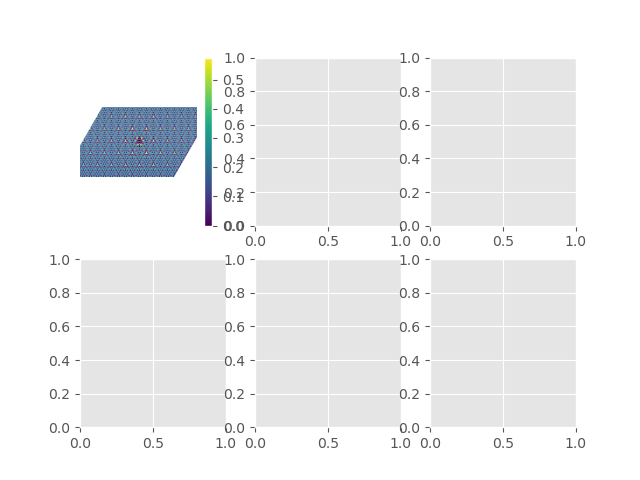

In [42]:
data = read_accumulator("new-data/hsweeps/0.07/48x48_r-0_t0.070000_j-0.250_20000000.20_0/tri-tri.dat")[0].reshape((48, 48, 2))
fig, ax = plt.subplots(2, 3)
plot2d_hex(ax[0,0], data)
plot_FT(ax[1,0], FT_hex(data), proj="logabs")

data = read_accumulator("new-data/hsweeps/0.07/48x48_r-0_t0.070000_j-0.025_20000000.20_0/tri-tri.dat")[0].reshape((48, 48, 2))
plot2d_hex(ax[0,1], data)
plot_FT(ax[1,1], FT_hex(data), proj="logabs")

data = read_accumulator("new-data/hsweeps/0.07/48x48_r-0_t0.070000_j0.000_20000000.20_0/tri-tri.dat")[0].reshape((48, 48, 2))
plot2d_hex(ax[0,2], data)
plot_FT(ax[1,2], FT_hex(data), proj="logabs")

## Trimer structure factor

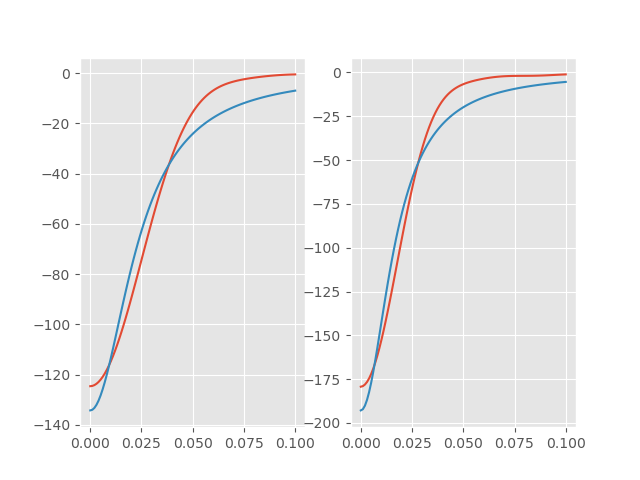

In [45]:
data1 = read_accumulator("new-data/vsweeps/binder/0.2d/60x60_r-0_t0.246970_j0.200_30000000.15_0/tri-tri.dat")[0].reshape((60, 60, 2))
data2 = read_accumulator("new-data/vsweeps/binder/0.2d/84x84_r-0_t0.246987_j0.200_30000000.15_0/tri-tri.dat")[0].reshape((84, 84, 2))

ft1 = FT_hex(data1)
ft2 = FT_hex(data2)
fig, ax = plt.subplots(1, 2)
xs = np.linspace(0, 0.1, 100)
ys = []
ys2 = []
for x in xs:
    ys.append(np.real(ft1((4/3, x))))
    ys2.append(np.real(ft2((4/3, x))))

def fun(x, A, B):
    return A / (1 + (B * x)**2)

ax[0].plot(xs, ys)
param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=(250, 0.1))
ax[0].plot(xs, fun(xs, *param))

ax[1].plot(xs, ys2)
param, _ = scipy.optimize.curve_fit(fun, xs, ys2, p0=(350, 0.1))
ax[1].plot(xs, fun(xs, *param))

Text(0.5, 1.0, 'J=-0.1 T=0.05 48x48')

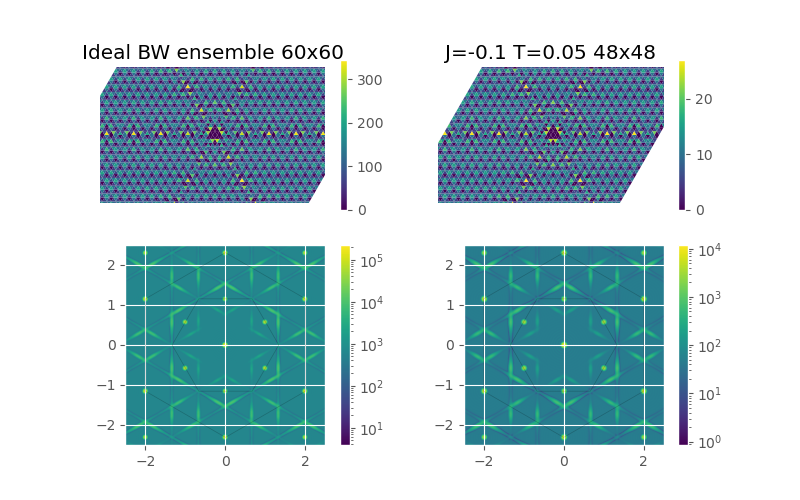

In [83]:
data1 = read_accumulator("data/idealbw/60x60_r-3_uinf_4j0.00_1000.1_0/tri-tri.dat")[0].reshape((60, 60, 2))
data2 = read_accumulator("data/vsweeps/-0.1/48x48_r-0_t0.0200_j-0.1000_40000000.5_0/tri-tri.dat")[0].reshape((48, 48, 2))
fig, ax = plt.subplots(2, 2, figsize=[8, 5], height_ratios=[6, 8])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot_FT(ax[1,0], FT_hex(data1), proj="logabs")
plot_FT(ax[1,1], FT_hex(data2), proj="logabs")
ax[0,0].set_title("Ideal BW ensemble 60x60")
ax[0,1].set_title("J=-0.1 T=0.05 48x48")

Text(0.5, 1.0, 'J=0.1 T=0.09 48x48')

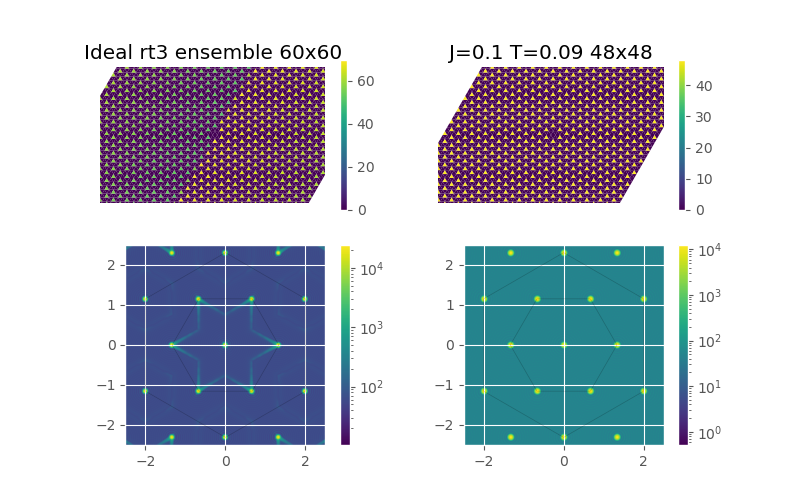

In [44]:
data1 = read_accumulator("data/idealrt3/60x60_r-0_t0.000000_j0.000_10.1_0/tri-tri.dat")[0].reshape((60, 60, 2))
data2 = read_accumulator("data/vsweeps/0.1/48x48_r-0_t0.0900_j0.1000_40000000.5_0/tri-tri.dat")[0].reshape((48, 48, 2))
fig, ax = plt.subplots(2, 2, figsize=[8, 5], height_ratios=[6, 8])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot_FT(ax[1,0], FT_hex(data1), proj="logabs")
plot_FT(ax[1,1], FT_hex(data2), proj="logabs")
ax[0,0].set_title("Ideal rt3 ensemble 60x60")
ax[0,1].set_title("J=0.1 T=0.09 48x48")

Text(0.5, 1.0, 'T=0.5 J=0 48x48')

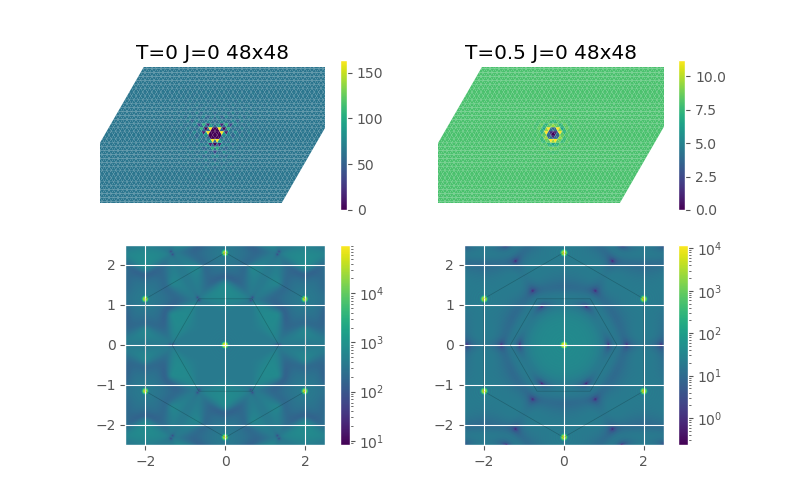

In [50]:
data1 = read_accumulator("data/rt3trans/48x48_r-3_uinf_4j0.00_20000000.5_0/tri-tri.dat")[0].reshape((48, 48, 2))
data2 = read_accumulator("data/vsweeps/0.01/48x48_r-0_t0.5000_j0.0100_40000000.5_0/tri-tri.dat")[0].reshape((48, 48, 2))
fig, ax = plt.subplots(2, 2, figsize=[8, 5], height_ratios=[6, 8])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot_FT(ax[1,0], FT_hex(data1), proj="logabs")
plot_FT(ax[1,1], FT_hex(data2), proj="logabs")
ax[0,0].set_title("T=0 J=0 48x48")
ax[0,1].set_title("T=0.5 J=0 48x48")

## Restricted mobility and confinement

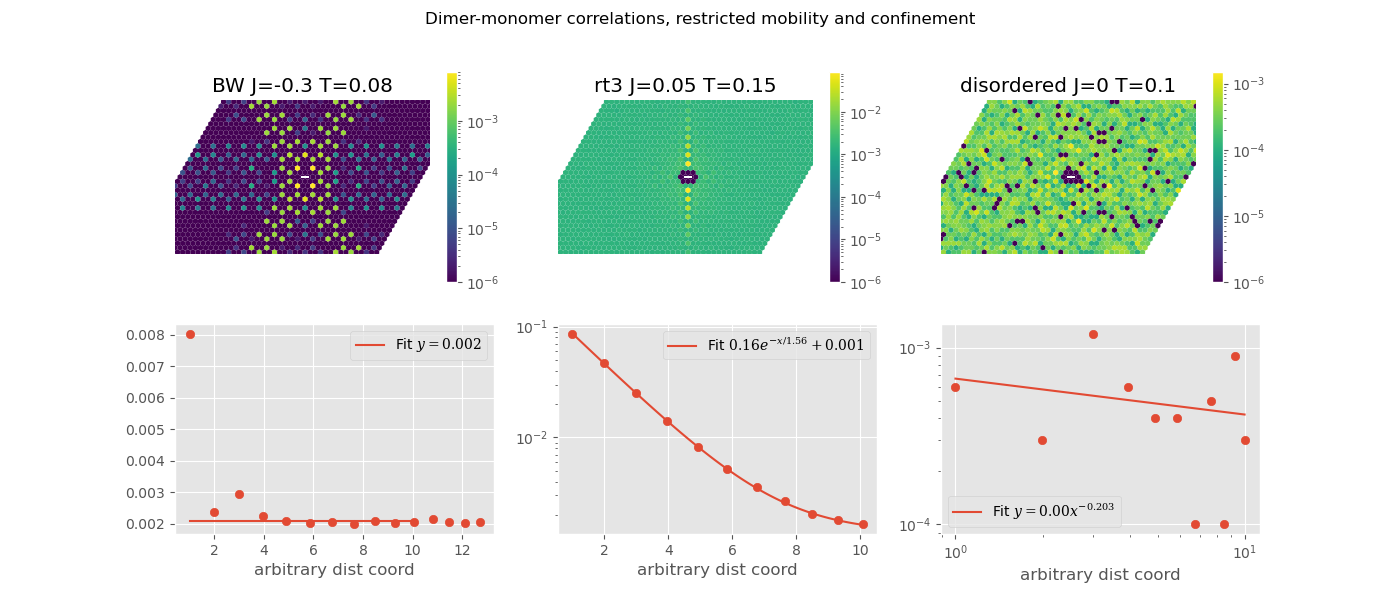

In [65]:
fig, ax = plt.subplots(2, 3, figsize=[14, 6])

fig.suptitle("Dimer-monomer correlations, restricted mobility and confinement")

data1 = read_accumulator("new-data/finite-t/j-0.3t0.08/48x48_r-3_t0.080000_j-0.300_20000000.20_0/mono-di.dat")[0].reshape((48, 48), order='F')
plot2d(ax[0,0], data1, log=True, show_dimer=True)
ax[0,0].set_title("BW J=-0.3 T=0.08")

data2 = read_accumulator("new-data/finite-t/j0.05t0.15/48x48_r-3_t0.150000_j0.050_20000000.20_0/mono-di.dat")[0].reshape((48, 48), order='F')
plot2d(ax[0,1], data2, log=True, show_dimer=True)
ax[0,1].set_title("rt3 J=0.05 T=0.15")

data3 = read_accumulator("new-data/finite-t/j0/48x48_r-3_t0.100000_j0.000_20000000.20_1/mono-di.dat")[0].reshape((48, 48), order='F')
plot2d(ax[0,2], data3, log=True, show_dimer=True)
ax[0,2].set_title("disordered J=0 T=0.1")

def mod(data, x, y):
    return data[x%(data.shape[0]), y%(data.shape[1])]

def symmetrize(data, cut):
    if cut == "perp":
        xs = np.arange(data.shape[0]//4)
        ys = np.zeros_like(xs, dtype=float)
        for i in xs:
            ys[i] = np.mean([mod(data, -i, 1+2*i), mod(data, 1+i, -1-2*i)][0])
    else:
        xs = np.arange(2*(data.shape[0]//6))
        ys = np.zeros_like(xs, dtype=float)
        for i in xs:
            ii = i // 2
            if i % 2 == 0:
                ys[i] = np.mean([mod(data, 0, 1+3*ii), mod(data, -3*ii, 1+3*ii),
                                 mod(data, 1+3*ii, -1-3*ii), mod(data, 1, -1-3*ii)])
            else:
                ys[i] = np.mean([mod(data, 1, 2+3*ii), mod(data, -2-3*ii, 2+3*ii),
                                 mod(data, 3+3*ii, -2-3*ii), mod(data, 0, -2-3*ii)])
    
    xs = np.sin(np.pi * xs/data.shape[0]) / (np.pi/data.shape[0]) 
    return xs[1:], ys[1:]

x = np.linspace(1, 10, 100)

xs, ys = symmetrize(data1, "zigzag")
ax[1, 0].scatter(xs, ys)
def fun(x, A):
    return np.ones_like(x) * A

param, _ = scipy.optimize.curve_fit(fun, xs[3:], ys[3:])
ax[1, 0].plot(x, fun(x, *param), label=f"Fit $y={param[0]:.3f}$")
ax[1, 0].set_xlabel("arbitrary dist coord")
ax[1, 0].legend()

xs, ys = symmetrize(data2, "perp")
ax[1, 1].scatter(xs, ys)
def fun(x, A, B, C):
    return B * np.exp(np.abs(x) / A) + C
param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=[-0.25, 1, 0])
ax[1, 1].plot(x, fun(x, *param), label=f"Fit ${param[1]:.2f}e^{{-x/{-param[0]:.2f}}}+{param[2]:.3f}$")
ax[1, 1].set_yscale("log")
ax[1, 1].set_xlabel("arbitrary dist coord")
ax[1, 1].legend()

xs, ys = symmetrize(data3, "perp")
ax[1, 2].scatter(xs, ys)
def fun(x, A, B):
    return B * np.power(np.abs(x), A)
param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=[-0.25, 1], bounds=([-5, 0], [-0.01, np.inf]))
ax[1, 2].plot(x, fun(x, *param), label=f"Fit $y={param[1]:.2f}x^{{{param[0]:.3f}}}$")
ax[1, 2].set_yscale("log")
ax[1, 2].set_xscale("log")
ax[1, 2].set_xlabel("arbitrary dist coord")
ax[1, 2].legend()

Text(0.5, 1.0, 'dis J=0 T=0.10')

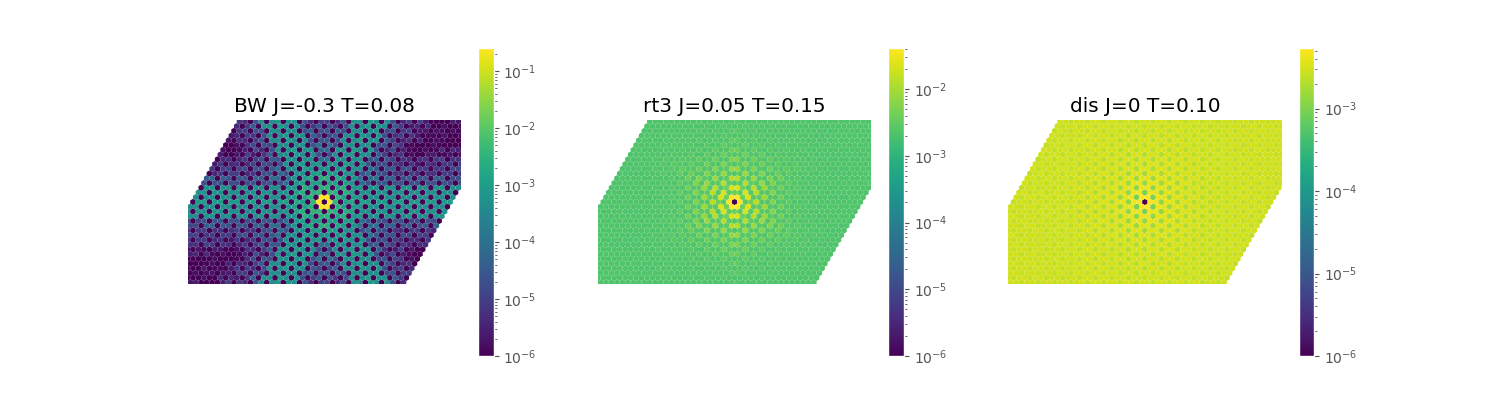

In [69]:
fig, ax = plt.subplots(1, 3, figsize=[15, 4])
data1 = read_accumulator("new-data/finite-t/j-0.3t0.08/48x48_r-3_t0.080000_j-0.300_20000000.20_0/mono-mono.dat")[0].reshape((48, 48), order='F')
plot2d(ax[0], data1, log=True)
ax[0].set_title("BW J=-0.3 T=0.08")

data1 = read_accumulator("new-data/finite-t/j0.05t0.15/48x48_r-3_t0.150000_j0.050_20000000.20_0/mono-mono.dat")[0].reshape((48, 48), order='F')
plot2d(ax[1], data1, log=True)
ax[1].set_title("rt3 J=0.05 T=0.15")

data1 = read_accumulator("new-data/finite-t/j0/48x48_r-3_t0.100000_j0.000_20000000.20_0/mono-mono.dat")[0].reshape((48, 48), order='F')
plot2d(ax[2], data1, log=True)
ax[2].set_title("dis J=0 T=0.10")

## CFT scaling hypothesis

Text(0.5, 1.0, 'mono-mono L=72')

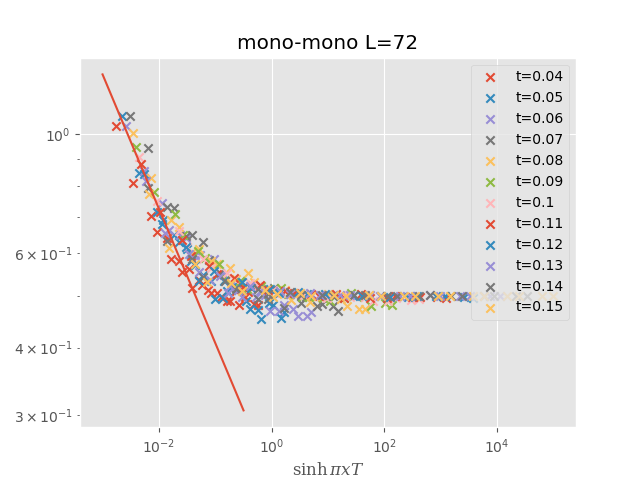

In [70]:
T, data = get_all_data("new-data/finite-t/j0/72*/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=100, by="t")
T, counts = get_all_data("new-data/finite-t/j0/72*/cluster-count.dat", lambda data, props: data[0][0], skip=100, by="t")

plt.figure()
xs = []
ys = []
for props, d, c in zip(T, data, counts):
    l = d.shape[0]
    x = np.arange(l)
    # scaledx = np.sin(np.pi * x/l) / (np.pi/l)
    scaledx = np.sinh(np.pi * x * props)
    scaledx = scaledx/l

    # c = d[32:39:3, 0].mean() + d[31:39:3, 0].mean()
    c = d[20:28:3, 0].mean() + d[19:28:3, 0].mean()
    d = d / c

    plt.scatter(scaledx[(x%3!=0)*(x<l//2)], d[(x%3!=0)*(x<l//2), 0], marker="x", label="t="+str(props))
    # plt.scatter(scaledx, d[:, 0], marker="x", label="t="+str(t))
    for i in range(d.shape[0]//2):
        if i % 3 == 0: continue
        xs.append(scaledx[i])
        ys.append(d[i, 0])

x = np.linspace(0.001, 1/np.pi, 100)
def fun(x, A):
    return A * np.power(np.abs(x), -0.25)
param, _ = scipy.optimize.curve_fit(fun, xs[:20], ys[:20])
plt.plot(x, fun(x, *param))

plt.xscale("log")
plt.yscale("log")
plt.xlabel("$\sinh \pi x T $")
plt.legend()
plt.title("mono-mono L=72")